# Removing Trends - Lab

## Introduction

In this lab, you'll practice your detrending skills!

## Objectives

You will be able to:
* Learn how to remove trends and seasonality
* Use a log transformation to minimize non-stationarity
* Use rolling means to reduce non-stationarity
* Use differencing to reduce non-stationarity

## Detrending the Airpassenger data

In [ ]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

# Import passengers.csv and set it as a time-series object. Plot the TS
passengers_df = pd.read_csv('passengers.csv')
passengers_df['Month'] = pd.to_datetime(passengers_df['Month'], format='%Y-%m-%d')
passengers_df.set_index('Month', inplace=True)
passengers_df.index
# passengers_df.info()
# passengers_df.head()

In [22]:
passengers_df.head()

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


## Create a stationarity check

At this stage, we can use the code from previous labs to create a function `stationarity_check(ts)` that takes in a time series object and performs stationarity checks including rolling statistics and the Dickey Fuller test. 

We want the output of the function to:
- Plot the original time series along with the rolling mean and rolling standard deviation in one plot
- Output the results of the Dickey-Fuller test

In [54]:
# Create a function to check for the stationarity of a given timeseries using rolling stats and DF test
# Collect and package the code from previous lab
from statsmodels.tsa.stattools import adfuller

def stationarity_check(ts, window=12):

    # Get rolling stats
    ts_rollmean = ts.rolling(window=window, center=False).mean()
    ts_rollstd = ts.rolling(window=window, center=False).std()
    
    # Plot rolling mean/rolling std against original
    fig = plt.figure(figsize=(12,7))
    orig = plt.plot(ts, color='blue',label='Original')
    mean = plt.plot(ts_rollmean, color='red', label='Rolling Mean')
    std = plt.plot(ts_rollstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    # perform TS transformation prior AdFuller test
    oned_array_ts = ts.iloc[:,0].values  # adfuller() function accepts only 1d array of time series so first convert it 
    dftest = adfuller(oned_array_ts)

    # Extract and display test results in a user friendly manner
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value

    print ('Results of Dickey-Fuller Test:')
    print(dfoutput)    

Use your newly created function on the airpassenger data set.

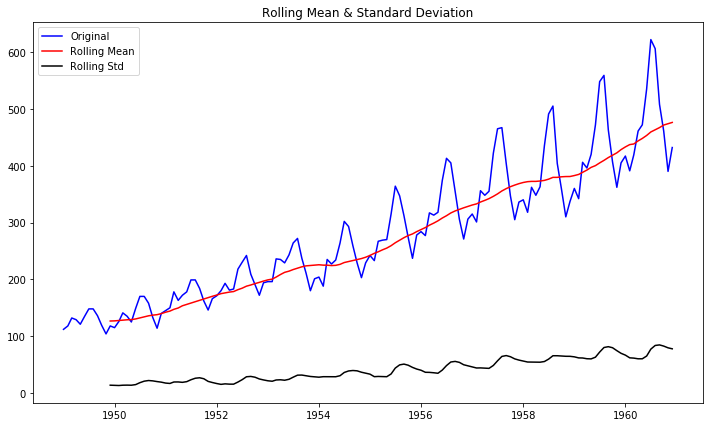

Results of Dickey-Fuller Test:
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


In [55]:
# Code here
stationarity_check(passengers_df, window=12)

## Perform a log() and sqrt() transform

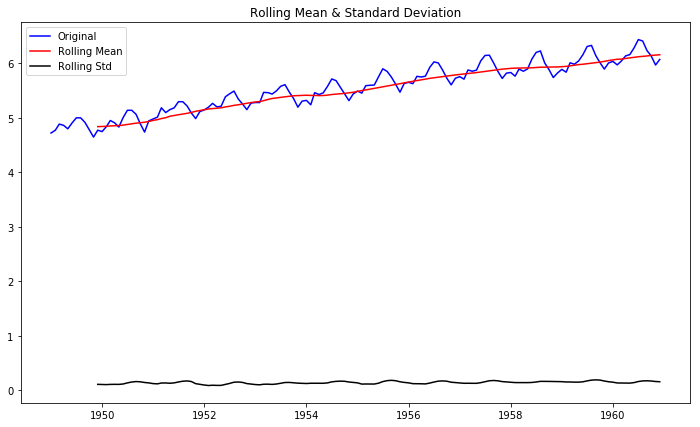

Results of Dickey-Fuller Test:
Test Statistic                  -1.717017
p-value                          0.422367
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


In [59]:
# Log transform timeseries and compare with original to check the effect
log_passengers_df = np.log(passengers_df)
stationarity_check(log_passengers_df)

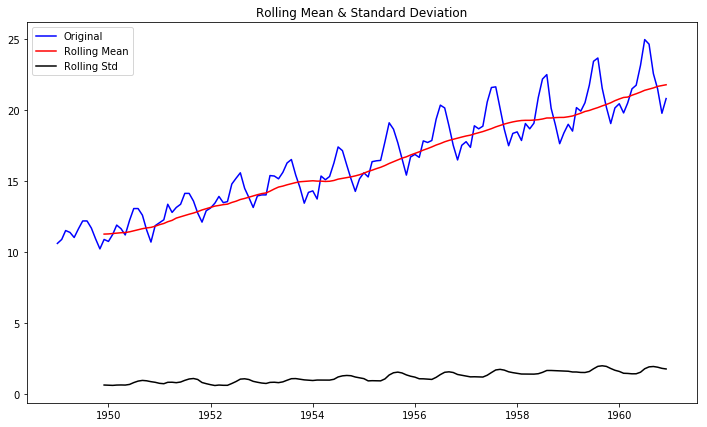

Results of Dickey-Fuller Test:
Test Statistic                  -0.345854
p-value                          0.918754
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


In [60]:
sqrt_passengers_df = np.sqrt(passengers_df)
stationarity_check(sqrt_passengers_df)

moving forward, let's keep working with the log transformed data before subtracting rolling mean, differencing, etc.

## Subtracting the rolling mean

Create a rolling mean using your log transformed time series, with a time window of 7. Plot the log-transformed time series and the rolling mean together.

<Figure size 1080x432 with 0 Axes>

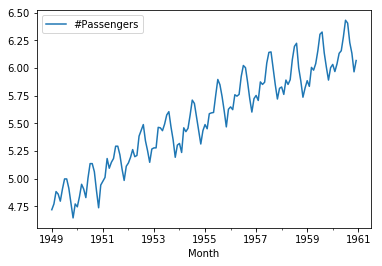

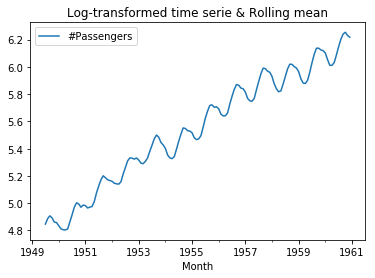

In [64]:
# your code here
log_rollmean = log_passengers_df.rolling(window=7).mean()
plt.figure(figsize=(15,6))
log_passengers_df.plot(label='Log-transformed time serie')
log_rollmean.plot(label='Rolling mean')
plt.legend()
plt.title('Log-transformed time serie & Rolling mean')
plt.show()

Now, subtract the rolling mean from the time series, look at the 10 first elements of the result and plot the result.

In [65]:
# Subtract the moving average from the original data and check head for Nans
data_minus_rolmean = log_passengers_df - log_rollmean
data_minus_rolmean.head(10)

,#Passengers
Month,
1949-01-01,NaN
1949-02-01,NaN
1949-03-01,NaN
1949-04-01,NaN
1949-05-01,NaN
1949-06-01,NaN
1949-07-01,0.150059
1949-08-01,0.110242
1949-09-01,0.005404


In [66]:
# Drop the NaN values from timeseries calculated above
data_minus_rolmean.dropna(inplace=True)

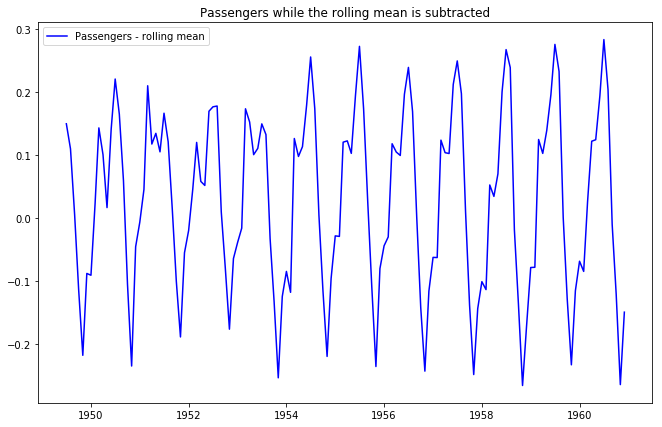

In [67]:
# Plot the result
fig = plt.figure(figsize=(11,7))
plt.plot(data_minus_rolmean, color='blue',label='Passengers - rolling mean')
plt.legend(loc='best')
plt.title('Passengers while the rolling mean is subtracted')
plt.show(block=False)

Finally, use your function `check_stationarity` to see if this series is considered stationary!

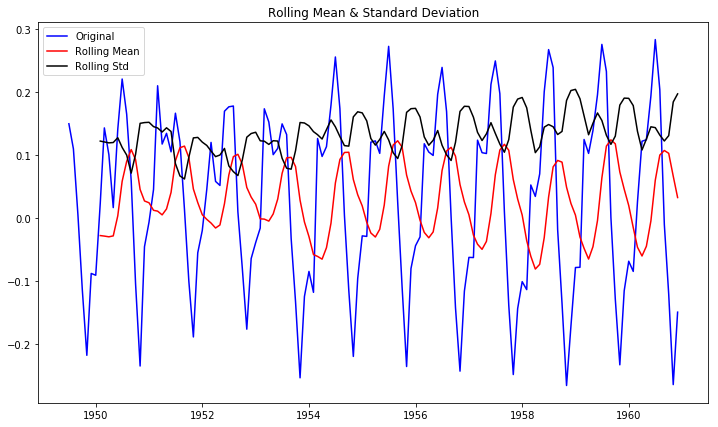

Results of Dickey-Fuller Test:
Test Statistic                  -2.348027
p-value                          0.156946
#Lags Used                      14.000000
Number of Observations Used    123.000000
Critical Value (1%)             -3.484667
Critical Value (5%)             -2.885340
Critical Value (10%)            -2.579463
dtype: float64


In [68]:
# Your code here
stationarity_check(data_minus_rolmean, window=8)

### Based on the visuals and on the Dickey-Fuller test, what do you conclude?

The Test statistic is still higher than our critical values at 1-5-10% so not stationary TS


## Subtracting the weighted rolling mean

Repeat all the above for the *weighter* rolling mean. Start from the log-transformed data again. Compare the Dickey-Fuller Test results. What do you conclude?

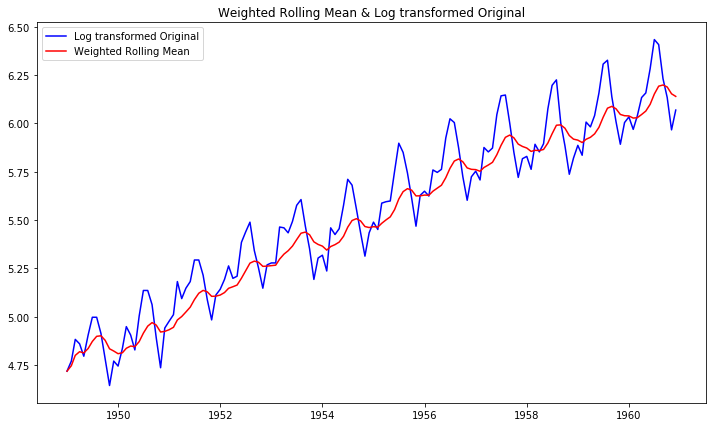

In [69]:
# Use Pandas ewma() to calculate Weighted Moving Average of ts_log
ts_log = np.log(passengers_df)
wma_log = ts_log.ewm(halflife=4).mean()

# Plot the original data with exp weighted average
fig = plt.figure(figsize=(12,7))
orig = plt.plot(ts_log, color='blue',label='Log transformed Original')
mean = plt.plot(wma_log, color='red', label='Weighted Rolling Mean')
plt.legend(loc='best')
plt.title('Weighted Rolling Mean & Log transformed Original')
plt.show(block=False)

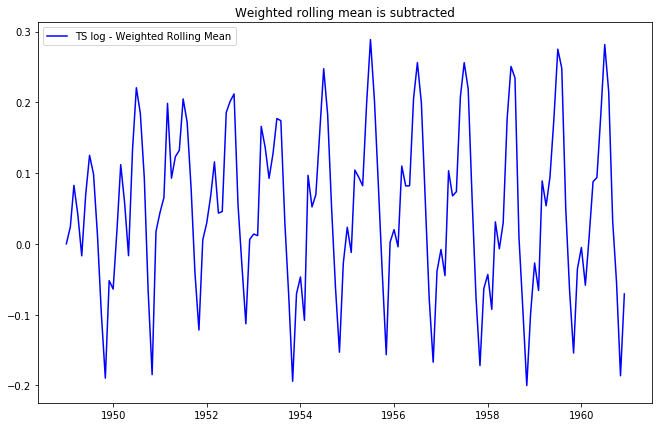

In [70]:
# Subtract the moving average from the original data and plot
data_minus_wma = ts_log - wma_log

fig = plt.figure(figsize=(11,7))
plt.plot(data_minus_wma, color='blue',label='TS log - Weighted Rolling Mean')
plt.legend(loc='best')
plt.title('Weighted rolling mean is subtracted')
plt.show(block=False)

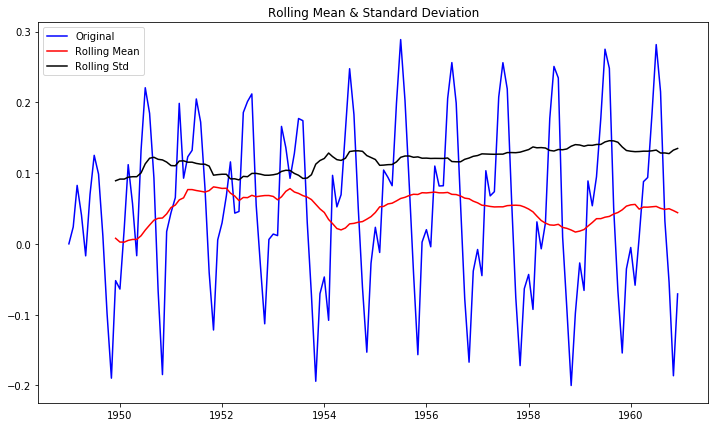

Results of Dickey-Fuller Test:
Test Statistic                  -3.297250
p-value                          0.015002
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


In [71]:
# do a stationarity check
stationarity_check(data_minus_wma)

### Based on the visuals and on the Dickey-Fuller test, what do you conclude?
With p-value < .05 & => not stationary


## Differencing

Using exponentially weighted moving averages, we seem to have removed the upward trend, but not the seasonality issue. Now use differencing to remove seasonality. Make sure you use the right amount of `periods`. Start from the log-transformed, exponentially weighted rolling mean-subtracted series.

After you differenced the series, run the `stationarity check` again.

In [13]:
# difference your data and look at the head

In [14]:
# plot your differenced time series

In [15]:
# drop nas

In [16]:
# perform the stationarity check

### Your conclusion

## Summary 

In this lab, you learned how to make time series stationary through using log transforms, rolling means and differencing.